# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [22]:
# Import libraries
import numpy as np
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import random
import progressbar

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics

# Pretty display for notebooks
%matplotlib inline
%config InlineBachend.figure_format = 'retina'


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [23]:
# Load data
azdias = pd.read_csv('Arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

azdias.head()

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [24]:
# Data shape
azdias.shape

(891221, 366)

In [25]:
# Data info
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [26]:
# Check object features
df_object = azdias.select_dtypes(include='object')

df_object.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W


#### Discusion

- LNR : like id don't use it in the analyses

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1: Preprocessing

#### 1.1.1:  Assess Missing Data


 - use feature summary from the previous project
 - use DIAS Attributes - Values 2017.xlsx to complet the feature summary 

In [27]:
# Load in the feature summary file.
feat_info = pd.read_csv('Arvato_data/AZDIAS_Feature_Summary.csv', sep = ';')
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [28]:
# feat_info shape
feat_info.shape

(85, 4)

In [29]:
feat_info.type.value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [30]:
# Laod DIAS Attributes
dias_attributes = pd.read_excel('Arvato_data/DIAS Attributes - Values 2017.xlsx', skiprows = [0])
del dias_attributes['Unnamed: 0']

# Drop NaN attribute
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isnull()]

# Drop attribute described in feat_info
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isin(feat_info.attribute)]

dias_attributes.head()

,Attribute,Description,Value,Meaning
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months


In [31]:
# dias_attributes shape
dias_attributes.shape

(233, 4)

In [32]:
# dias_attributes Meanning counts
dias_attributes.Meaning.value_counts(dropna=False)

unknown                                             172
no transaction known                                 34
highest activity within the last 12 months           12
no transactions known                                10
no Online-transactions within the last 12 months      3
very low car quote                                    1
Universal                                             1
Name: Meaning, dtype: int64

In [33]:
# Investigate attribute with unknown Meaning
unknown_Meaning = dias_attributes[dias_attributes['Meaning']=='unknown']

# Keep only attribute of azdias
unknown_Meaning = unknown_Meaning[unknown_Meaning['Attribute'].isin(azdias.columns)]

# unknown_Meaning shape
unknown_Meaning.head()

,Attribute,Description,Value,Meaning
765,KBA05_ALTER1,share of car owners less than 31 years old,"-1, 9",unknown
771,KBA05_ALTER2,share of car owners inbetween 31 and 45 years ...,"-1, 9",unknown
777,KBA05_ALTER3,share of car owners inbetween 45 and 60 years ...,"-1, 9",unknown
783,KBA05_ALTER4,share of cars owners elder than 61 years,"-1, 9",unknown
790,KBA05_ANHANG,share of trailers in the microcell,"-1, 9",unknown


#### Guest attributes types

In [34]:
# Get first part of attribute
unknown_Meaning['first_att'] = unknown_Meaning.Attribute.apply(lambda x: x.split('_')[0])

In [35]:
unknown_Meaning.first_att.value_counts(dropna=False)

KBA13    106
KBA05     58
Name: first_att, dtype: int64

In [36]:
# Value of KBA05_ALTER1  
azdias.KBA05_ALTER1.value_counts(dropna=False)

 2.0    228625
 1.0    167046
 3.0    166129
NaN     133324
 0.0    102789
 4.0     78522
 9.0     14786
Name: KBA05_ALTER1, dtype: int64

In [37]:
# Values of KBA13_VORB_1  
azdias.KBA13_VORB_1.value_counts(dropna=False)

 3.0    361449
 2.0    167076
 4.0    158150
NaN     105800
 1.0     50939
 5.0     47807
Name: KBA13_VORB_1, dtype: int64

## Discusion

KBA13 and KBA05 are ordinal variabels

In [38]:
unknown_Meaning['type'] = 'ordinal'

In [39]:
# Investigate attribute with no transaction known
no_transaction = dias_attributes[dias_attributes['Meaning'].isin(['no transaction known',
                                                                  'no transactions known'])]

# Keep only attribute of azdias
no_transaction = no_transaction[no_transaction['Attribute'].isin(azdias.columns)]

# Get first part of attribute
no_transaction['first_att'] = no_transaction.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
no_transaction

,Attribute,Description,Value,Meaning,first_att
138,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known,D19
145,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known,D19
305,D19_GESAMT_ANZ_12,transaction activity TOTAL POOL in the last 12...,0,no transactions known,D19
312,D19_GESAMT_ANZ_24,transaction activity TOTAL POOL in the last 24...,0,no transactions known,D19
478,D19_TELKO_ANZ_12,transaction activity TELCO in the last 12 months,0,no transactions known,D19
485,D19_TELKO_ANZ_24,transaction activity TELCO in the last 24 months,0,no transactions known,D19
546,D19_VERSAND_ANZ_12,transaction activity MAIL-ORDER in the last 12...,0,no transactions known,D19
553,D19_VERSAND_ANZ_24,transaction activity MAIL-ORDER in the last 24...,0,no transactions known,D19
617,D19_VERSI_ANZ_12,transaction activity INSURANCE in the last 12 ...,0,no transactions known,D19
624,D19_VERSI_ANZ_24,transaction activity INSURANCE in the last 24 ...,0,no transactions known,D19


In [40]:
# Values of D19_BANKEN_ANZ_12  
azdias.D19_BANKEN_ANZ_12.value_counts(dropna=False)

0    831734
1     29771
2     18067
3      5708
4      4082
5      1483
6       376
Name: D19_BANKEN_ANZ_12, dtype: int64

## Discusion

D19 are ordinal variabels

In [41]:
no_transaction['type'] = 'ordinal'

In [42]:
# Investigate the rest of attributes 
sub_dias = dias_attributes[~dias_attributes['Meaning'].isin(['no transaction known',
                                                             'no transactions known',
                                                            'unknown'])]

# Keep only attribute of azdias
sub_dias = sub_dias[sub_dias['Attribute'].isin(azdias.columns)]

# Get first part of attribute
sub_dias['first_att'] = sub_dias.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
sub_dias

,Attribute,Description,Value,Meaning,first_att
152,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
186,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
196,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19
206,D19_BANKEN_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
319,D19_GESAMT_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
329,D19_GESAMT_OFFLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
339,D19_GESAMT_ONLINE_DATUM,actuality of the last transaction with the com...,1,highest activity within the last 12 months,D19
349,D19_GESAMT_ONLINE_QUOTE_12,amount of online transactions within all trans...,0,no Online-transactions within the last 12 months,D19
384,D19_KONSUMTYP,consumption type,1,Universal,D19
492,D19_TELKO_DATUM,actuality of the last transaction for the segm...,1,highest activity within the last 12 months,D19


In [43]:
# Values of D19_KONSUMTYP
azdias.D19_KONSUMTYP.value_counts(dropna=False)

NaN     257113
 9.0    254296
 1.0    117912
 4.0     78262
 6.0     56562
 3.0     53330
 2.0     49324
 5.0     24422
Name: D19_KONSUMTYP, dtype: int64

### Discusion

All attribut in sub_dias are ordinal except D19_KONSUMTYP which is categorical

In [44]:
sub_dias['type'] = sub_dias.Meaning.apply(
    lambda x: 'categorical' if x=='Universal' else 'ordinal')

In [45]:
# Make a dataframe of features description
def_cl = lambda x: [str(k) for k in str(x).split(',')]
unknown_Meaning['missing_or_unknown'] = unknown_Meaning.Value.apply(def_cl)

# drop colums
unknown_Meaning.drop(['Description', 'Value', 'Meaning', 'first_att'],
                    axis=1, inplace=True)

# change columns name
unknown_Meaning.columns = ['attribute', 'type', 'missing_or_unknown']

unknown_Meaning.head()

,attribute,type,missing_or_unknown
765,KBA05_ALTER1,ordinal,"[-1, 9]"
771,KBA05_ALTER2,ordinal,"[-1, 9]"
777,KBA05_ALTER3,ordinal,"[-1, 9]"
783,KBA05_ALTER4,ordinal,"[-1, 9]"
790,KBA05_ANHANG,ordinal,"[-1, 9]"


In [46]:
# no_transaction
no_transaction['missing_or_unknown'] = no_transaction.Value.apply(lambda
                                                                 x: [str(x)])

# drop colums
no_transaction.drop(['Description', 'Value', 'Meaning', 'first_att'],
                    axis=1, inplace=True)

# change columns name
no_transaction.columns = ['attribute', 'type', 'missing_or_unknown']

no_transaction.head()

,attribute,type,missing_or_unknown
138,D19_BANKEN_ANZ_12,ordinal,[0]
145,D19_BANKEN_ANZ_24,ordinal,[0]
305,D19_GESAMT_ANZ_12,ordinal,[0]
312,D19_GESAMT_ANZ_24,ordinal,[0]
478,D19_TELKO_ANZ_12,ordinal,[0]


In [47]:

sub_dias['missing_or_unknown'] = sub_dias.Value.apply(lambda x: [])

# drop colums
sub_dias.drop(['Description', 'Value', 'Meaning', 'first_att'],
              axis=1, inplace=True)

# change columns name
sub_dias.columns = ['attribute', 'type', 'missing_or_unknown']

sub_dias.head()

,attribute,type,missing_or_unknown
152,D19_BANKEN_DATUM,ordinal,[]
186,D19_BANKEN_OFFLINE_DATUM,ordinal,[]
196,D19_BANKEN_ONLINE_DATUM,ordinal,[]
206,D19_BANKEN_ONLINE_QUOTE_12,ordinal,[]
319,D19_GESAMT_DATUM,ordinal,[]


In [48]:
# feat_info
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda 
                                                                        x: x[1:-1].split(','))

# drop information_level 
feat_info.drop(['information_level'], axis=1, inplace=True)

feat_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [49]:
# concat feat info
new_feat_info = pd.concat([feat_info, sub_dias, no_transaction,
                           unknown_Meaning], ignore_index=True)

In [50]:
# shape of new_feat_info
new_feat_info.shape

(276, 3)

In [51]:
# Columns without type
col = azdias.columns[~azdias.columns.isin(new_feat_info.attribute)]


In [52]:
# Check object features
sub_object = azdias[col].select_dtypes(include='object')
sub_object.head()

,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM
0,NaN,NaN
1,NaN,1992-02-10 00:00:00
2,D19_UNBEKANNT,1992-02-12 00:00:00
3,D19_UNBEKANNT,1997-04-21 00:00:00
4,D19_SCHUHE,1992-02-12 00:00:00


In [53]:
sub_object.D19_LETZTER_KAUF_BRANCHE.value_counts(dropna=False)

NaN                       257113
D19_UNBEKANNT             195338
D19_VERSICHERUNGEN         57734
D19_SONSTIGE               44722
D19_VOLLSORTIMENT          34812
D19_SCHUHE                 32578
D19_BUCH_CD                28754
D19_VERSAND_REST           26034
D19_DROGERIEARTIKEL        24072
D19_BANKEN_DIREKT          23273
D19_BEKLEIDUNG_REST        21796
D19_HAUS_DEKO              20858
D19_TELKO_MOBILE           14447
D19_ENERGIE                12084
D19_TELKO_REST             11472
D19_BANKEN_GROSS           10550
D19_BEKLEIDUNG_GEH         10272
D19_KINDERARTIKEL           7301
D19_FREIZEIT                7257
D19_TECHNIK                 7002
D19_LEBENSMITTEL            6458
D19_BANKEN_REST             5247
D19_RATGEBER                4931
D19_NAHRUNGSERGAENZUNG      4061
D19_DIGIT_SERV              3577
D19_REISEN                  3122
D19_TIERARTIKEL             2578
D19_SAMMELARTIKEL           2443
D19_HANDWERK                2227
D19_WEIN_FEINKOST           2164
D19_GARTEN

In [54]:
describe = azdias[col].describe()
describe

,LNR,AKT_DAT_KL,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_KINDER,ANZ_STATISTISCHE_HAUSHALTE,CJT_KATALOGNUTZER,...,STRUKTURTYP,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11
count,8.912210e+05,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,817722.000000,798073.000000,886367.000000,...,793947.000000,793435.000000,793435.000000,817722.000000,793947.00000,817722.00000,770025.000000,815304.000000,815304.000000,815304.000000
mean,6.372630e+05,4.421928,11.745392,13.402658,14.476013,15.089627,13.700717,0.154018,7.599356,3.335264,...,2.539212,3.223125,4.017526,0.090067,4.58576,0.43882,2.417322,6.001214,7.532130,5.945972
std,2.572735e+05,3.638805,4.097660,3.243300,2.712427,2.452932,5.079849,0.502389,14.332201,1.493633,...,0.754926,1.255785,1.118399,0.286278,8.47152,1.14329,1.166572,2.856091,3.247789,2.771464
min,1.916530e+05,1.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,1.000000,8.000000,11.000000,13.000000,14.000000,11.000000,0.000000,1.000000,2.000000,...,2.000000,2.000000,3.000000,0.000000,0.00000,0.00000,2.000000,3.000000,5.000000,4.000000
50%,6.372630e+05,3.000000,12.000000,14.000000,15.000000,15.000000,14.000000,0.000000,3.000000,4.000000,...,3.000000,3.000000,4.000000,0.000000,1.00000,0.00000,2.000000,6.000000,8.000000,6.000000
75%,8.600680e+05,9.000000,15.000000,16.000000,17.000000,17.000000,17.000000,0.000000,9.000000,5.000000,...,3.000000,4.000000,5.000000,0.000000,5.00000,0.00000,3.000000,9.000000,10.000000,8.000000
max,1.082873e+06,9.000000,18.000000,18.000000,18.000000,18.000000,25.000000,11.000000,449.000000,5.000000,...,3.000000,5.000000,5.000000,1.000000,45.00000,5.00000,4.000000,11.000000,13.000000,11.000000


In [55]:
# Data information
dias_info = pd.read_excel('Arvato_data/DIAS Information Levels - Attributes 2017.xlsx', skiprows = [0])
del dias_info['Unnamed: 0']
dias_info = dias_info[dias_info.Attribute.isin(col)]

dias_info

,Information level,Attribute,Description,Additional notes
67,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN


In [56]:
# List of columns to drop

col_to_drop = list(sub_object.columns)

## Discusion

 - Drop the two object variable
 - auther variable as numeric variables


In [57]:
last_att_info = pd.DataFrame({'attribute': list(describe.columns)})
last_att_info['type'] = 'numeric'
last_att_info['missing_or_unknown'] = last_att_info['type'].apply(lambda
                                                                 x:[])

last_att_info.head()

,attribute,type,missing_or_unknown
0,LNR,numeric,[]
1,AKT_DAT_KL,numeric,[]
2,ALTER_KIND1,numeric,[]
3,ALTER_KIND2,numeric,[]
4,ALTER_KIND3,numeric,[]


In [58]:
# concat last_att_info and new_feat_info
new_feat_info = pd.concat([new_feat_info, last_att_info], ignore_index=True)

new_feat_info.shape

(364, 3)

#### Convert Missing Value Codes to NaNs

In [59]:
# Identify missing or unknown data values and convert them to NaNs.
for attrib, missing_values in zip(new_feat_info['attribute'], 
                                  new_feat_info['missing_or_unknown']):
    if len(missing_values) != 0:
        for value in missing_values:
            if value.isnumeric() or value.lstrip('-').isnumeric():
                value = int(value)
            azdias.loc[azdias[attrib] == value, attrib] = np.nan

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [60]:
# Drop col_to_drop
azdias.drop(col_to_drop, axis=1, inplace=True)

# check shape
azdias.shape

(891221, 364)

In [61]:
# Missing Data in Each Column
count_nan = azdias.isnull().sum()/len(azdias)

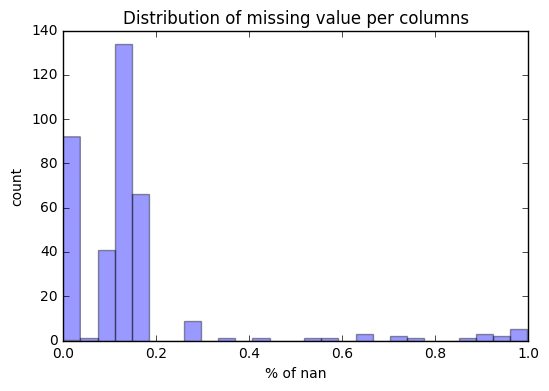

In [62]:
plt.figure()
sns.distplot(count_nan.values, kde=False)
plt.ylabel('count')
plt.xlabel('% of nan')
plt.title('Distribution of missing value per columns')
plt.show()

#### Discusion

Drop columns that have more than 30% of missing values

In [63]:
# Get columns that have more than 30% of nan
more_30 = count_nan[count_nan > 0.3]
missing_col = list(more_30.index)
len(missing_col)

21

In [64]:
# Remove the outlier missing_col from the dataset. 
azdias.drop(missing_col, axis=1, inplace=True)

azdias.shape

(891221, 343)

####  Assess Missing Data in Each Row

In [65]:
# Missing Data in Each Column
row_nan = azdias.isnull().sum(axis=1)

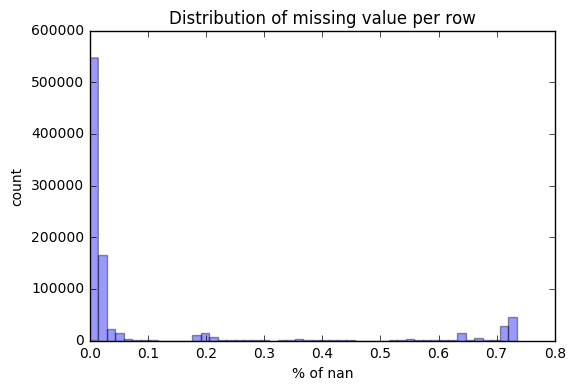

In [66]:
plt.figure()
sns.distplot(row_nan.values/343, kde=False)
plt.ylabel('count')
plt.xlabel('% of nan')
plt.title('Distribution of missing value per row')
plt.show()

#### Discusion

Drop rows contain more than 50% of missing value

In [67]:
# Drop row that contains more than 50% of nan values
azdias = azdias.loc[row_nan[row_nan<=0.5*343].index]

azdias.reset_index(drop=True, inplace=True)

azdias.shape

(791987, 343)

In [68]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791987 entries, 0 to 791986
Columns: 343 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(288), int64(51), object(4)
memory usage: 2.0+ GB


### Step 1.2: Select and Re-Encode Features

In [69]:
new_feat_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [70]:
# keep only azdias attribute 
final_feat_info = new_feat_info[new_feat_info.attribute.isin(azdias.columns)]

len(final_feat_info)

343

In [71]:
# How many features are there of each data type?
final_feat_info.type.value_counts(dropna=False)

ordinal        229
numeric         89
categorical     19
mixed            6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

In [72]:
final_feat_info.head()

,attribute,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]
5,FINANZ_SPARER,ordinal,[-1]


In [73]:
# Get list of Categorical Features
Cat_feat = list(final_feat_info.attribute[
        final_feat_info.type=='categorical'])

binary_num_attribute = []
binary_str_attribute = []
multi_level_attribute = []

for att in Cat_feat:
    dtype =  azdias[att].dtype
    count =  len(azdias[att].value_counts())
    
    if count>2:
        multi_level_attribute.append(att)
    else:
        if dtype=='object':
            binary_str_attribute.append(att)
        else:
            binary_num_attribute.append(att)

In [74]:
# binary_num_attribute
binary_num_attribute

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

In [75]:
# binary_str_attribute
binary_str_attribute

['OST_WEST_KZ']

In [76]:
# multi_level_attribute
multi_level_attribute

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'D19_KONSUMTYP']

In [77]:
# Re-encode OST_WEST_KZ as dummy variable
azdias['OST_WEST_KZ'] =  azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [78]:
# Convert cat to cat to dummies variables

def encode_cat(df, list_cat):
    list_df_dum = []
    for col_dum in list_cat:
        list_df_dum.append(pd.get_dummies(df[col_dum], prefix=col_dum))
    
    assert len(list_df_dum) == len(list_cat)
    
    # Drop cat col from df
    df.drop(list_cat, axis=1, inplace=True)
    list_df_dum.append(df)
    df = pd.concat(list_df_dum, axis=1)
    
    return df

In [79]:
new_azdias = encode_cat(azdias, multi_level_attribute)

### Discusion

- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

## Step 1.2.2: Engineer Mixed-Type Features

In [80]:
mixed_att = list(final_feat_info.attribute[final_feat_info.type=='mixed'])
mixed_att

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

**"PRAEGENDE_JUGENDJAHRE"**:

combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.

In [81]:
# Map decade
dic_dec = { 1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80,14: 90,
           15: 90, np.nan : np.nan, -1: np.nan, 0: np.nan}

# Map mouvement
dic_mov = { 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1,14: 0, 15: 1,
           np.nan : np.nan, -1: np.nan, 0: np.nan}

new_azdias["PRAEGENDE_JUGENDJAHRE_dec"] = new_azdias["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)

# Mainstream : 0, Avantgarde : 1
new_azdias["PRAEGENDE_JUGENDJAHRE_mov"] = new_azdias["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)

# Drop PRAEGENDE_JUGENDJAHRE
new_azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

**"CAMEO_INTL_2015"**

combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.

In [82]:
def encode_CAMEO_INTL_2015(x):
    
    if np.isnan(x):
        return [np.nan, np.nan]
    else :
        x = str(x).split('.')[0]
        return [int(x[0]), int(x[1])]

new_azdias["CAMEO_INTL_2015"] = new_azdias["CAMEO_INTL_2015"].astype('float')
new_azdias["CAMEO_INTL_2015"] = new_azdias["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

# CAMEO_INTL_2015_wealth
new_azdias["CAMEO_INTL_2015_wealth"] = new_azdias["CAMEO_INTL_2015"].apply(lambda x: x[0])

# CAMEO_INTL_2015_life_stage
new_azdias["CAMEO_INTL_2015_life_stage"] = new_azdias["CAMEO_INTL_2015"].apply(lambda x: x[1])

# drop CAMEO_INTL_2015
new_azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)

**LP_LEBENSPHASE_FEIN**

parent, famillies = midele age
advanced age == higer age
wealthy == homeowener = high

In [83]:
life_stage = {1:'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

fine_scale = {1:'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

new_azdias['LP_life_stage'] = new_azdias['LP_LEBENSPHASE_FEIN'].map(life_stage)
new_azdias['LP_fine_scale'] = new_azdias['LP_LEBENSPHASE_FEIN'].map(fine_scale)

# Drop LP_LEBENSPHASE_FEIN 
new_azdias.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [84]:
# R-encode LP_life_stage and LP_fine_scale as ordinal
dic_life = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3, 'retirement_age': 4}
dic_scale = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

new_azdias['LP_life_stage'] = new_azdias['LP_life_stage'].map(dic_life)
new_azdias['LP_fine_scale'] = new_azdias['LP_fine_scale'].map(dic_scale)

 LP_LEBENSPHASE_GROB same as  LP_LEBENSPHASE_FEIN. Therfore I will drop it.

In [85]:
new_azdias.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

**WOHNLAGE**
encode it as a dummy variabels

In [86]:
# replace 0 by nan
new_azdias['WOHNLAGE'] = new_azdias['WOHNLAGE'].replace(0, np.nan)

# Get dummumies variable
WOHNLAGE = pd.get_dummies(new_azdias['WOHNLAGE'], prefix='WOHNLAGE')

# Drop WOHNLAGE
new_azdias.drop('WOHNLAGE', axis=1, inplace=True)

# concat WOHNLAGE with new_azdias
new_azdias = pd.concat([new_azdias, WOHNLAGE], axis=1)

**PLZ8_BAUMAX**

encode it as a dummy variabels

In [87]:
# Get dummumies variable
PLZ8_BAUMAX = pd.get_dummies(new_azdias['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

# Drop PLZ8_BAUMAX
new_azdias.drop('PLZ8_BAUMAX', axis=1, inplace=True)

# concat WOHNLAGE with new_azdias
new_azdias = pd.concat([new_azdias, PLZ8_BAUMAX], axis=1)

## Discusion

Back

### Step 1.3: Create a Cleaning Function


In [88]:
def clean_data(df, drop_col=True, drop_row=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Drop 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM'
    df.drop(col_to_drop, axis=1, inplace=True)
    
    # convert missing value codes into NaNs
    for attrib, missing_values in zip(new_feat_info['attribute'],
                                      new_feat_info['missing_or_unknown']):
        if len(missing_values) != 0:
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attrib] == value, attrib] = np.nan
        
    # remove selected columns
    if drop_col:
        df.drop(missing_col, axis=1, inplace=True)
    
    # assessing missing value per row
    row_nan = df.isnull().sum(axis=1)
    a = df.shape[1]
    
    if drop_row:
        df = df.loc[row_nan[row_nan<=0.5*a].index]
        df.reset_index(drop=True, inplace=True)

    # Re-encode OST_WEST_KZ as dummy variable
    df['OST_WEST_KZ'] =  df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # Convert cat to cat to dummies variables
    df = encode_cat(df, multi_level_attribute)
    
    # Mix
    df["PRAEGENDE_JUGENDJAHRE_dec"] = df["PRAEGENDE_JUGENDJAHRE"].map(dic_dec)

    # Mainstream : 0, Avantgarde : 1
    df["PRAEGENDE_JUGENDJAHRE_mov"] = df["PRAEGENDE_JUGENDJAHRE"].map(dic_mov)

    # Drop PRAEGENDE_JUGENDJAHRE
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # re
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].astype('float')
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

    # CAMEO_INTL_2015_wealth
    df["CAMEO_INTL_2015_wealth"] = df["CAMEO_INTL_2015"].apply(lambda x: x[0])

    # CAMEO_INTL_2015_life_stage
    df["CAMEO_INTL_2015_life_stage"] = df["CAMEO_INTL_2015"].apply(lambda x: x[1])

    # drop CAMEO_INTL_2015
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #
    df['LP_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(life_stage)
    df['LP_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(fine_scale)

    # Drop LP_LEBENSPHASE_FEIN 
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    df['LP_life_stage'] = df['LP_life_stage'].map(dic_life)
    df['LP_fine_scale'] = df['LP_fine_scale'].map(dic_scale)
    
    # Drop LP_LEBENSPHASE_GROB
    df.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    # replace 0 by nan
    df['WOHNLAGE'] = df['WOHNLAGE'].replace(0, np.nan)

    # Get dummumies variable
    WOHNLAGE = pd.get_dummies(df['WOHNLAGE'], prefix='WOHNLAGE')

    # Drop WOHNLAGE
    df.drop('WOHNLAGE', axis=1, inplace=True)

    # concat WOHNLAGE with new_azdias
    df = pd.concat([df, WOHNLAGE], axis=1)
    
    # Get dummumies variable
    PLZ8_BAUMAX = pd.get_dummies(df['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

    # Drop PLZ8_BAUMAX
    df.drop('PLZ8_BAUMAX', axis=1, inplace=True)

    # concat WOHNLAGE with new_azdias
    df = pd.concat([df, PLZ8_BAUMAX], axis=1)
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

In [68]:
# drop LNR from data to process
LNR_azdias = new_azdias['LNR']
new_azdias.drop('LNR', axis=1, inplace=True)

In [7]:
# Imputer
Imp =  Imputer(missing_values=np.nan, strategy='median')
new_azdias = pd.DataFrame(Imp.fit_transform(new_azdias.values),
                          columns= new_azdias.columns)

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


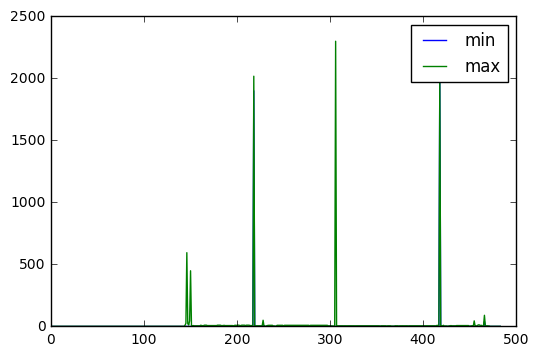

In [71]:
# Check features range
describe_azdias = new_azdias.describe()

plt.figure()
plt.plot(describe_azdias.loc['min'].values, label= 'min')
plt.plot(describe_azdias.loc['max'].values, label= 'max')
plt.legend()
plt.show()

In [8]:
# Apply feature scaling to the general population demographics data.
scaler = RobustScaler()
scaled_azdias = pd.DataFrame(scaler.fit_transform(new_azdias.values),
                          columns= new_azdias.columns)

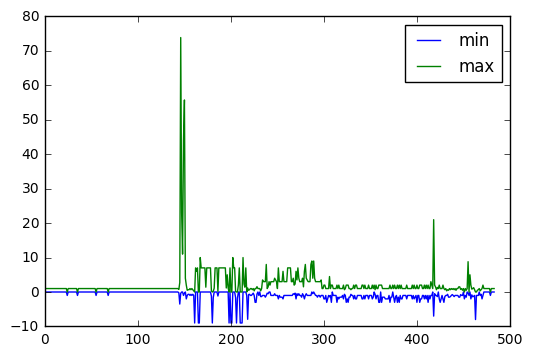

In [73]:
# Check features range
describe_2 = scaled_azdias.describe()

plt.figure()
plt.plot(describe_2.loc['min'].values, label= 'min')
plt.plot(describe_2.loc['max'].values, label= 'max')
plt.legend()
plt.show()

### Step 2.2: Perform Dimensionality Reduction


In [78]:
# Apply PCA to the azdias data.
pca = PCA()
azdias_pca = pca.fit_transform(scaled_azdias)

In [79]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]),
                    va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

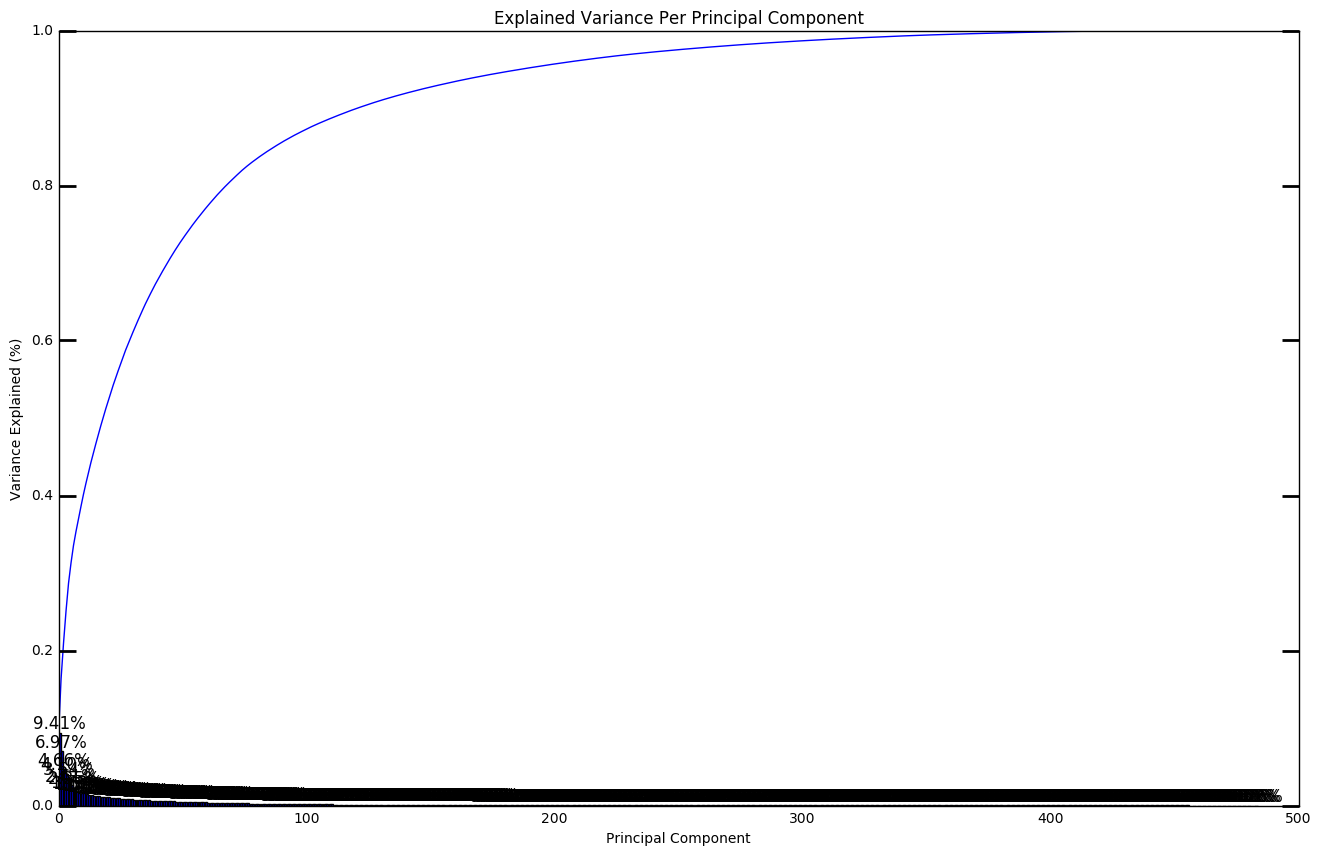

In [80]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [82]:
# Re-apply PCA to the data whith 200 components.
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(scaled_azdias)

### Discussion 2.2: Perform Dimensionality Reduction

Back

### Interpret Principal Components

In [84]:
# Map weights for the principal component to corresponding feature names

def print_component(pca, comp):
    df = pd.DataFrame({ 'featurs': scaled_azdias.columns,
                       'weight component_ '+ str(comp): pca.components_[comp]})
    df['abs_W'] = df['weight component_ '+ str(comp)].abs()  
    df = df.sort_values(by=['abs_W'],  ascending=False)
    df = df[['featurs', 'weight component_ '+ str(comp)]]
    return df

In [85]:
# Check the first principal component
df_pca_1 = print_component(pca, 0)
df_pca_1.head()

,featurs,weight component_ 0
184,D19_HAUS_DEKO,0.230474
170,D19_BEKLEIDUNG_REST,0.220408
187,D19_KOSMETIK,0.205197
185,D19_KINDERARTIKEL,0.195544
192,D19_REISEN,0.190283


In [86]:
# Check the first principal component
df_pca_1 = print_component(pca, 1)
df_pca_1.head()

,featurs,weight component_ 1
289,KBA05_SEG8,0.245930
286,KBA05_SEG5,0.243792
287,KBA05_SEG6,0.242883
238,KBA05_ANHANG,0.229853
251,KBA05_HERST1,0.225067


## Discusion

## Clustering

Apply Clustering to General Population

In [188]:
# Compute the average within-cluster distances.


def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center, random_state=42, n_jobs=-1)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit 
    score = np.abs(model.score(data))
    
    return score

In [191]:
# Apply the elbow method
score_list = []
centers = np.arange(2, 15, 1)


for center in centers: 
    
    # Append score to 
    score_list.append(get_kmeans_score(azdias_pca, center))

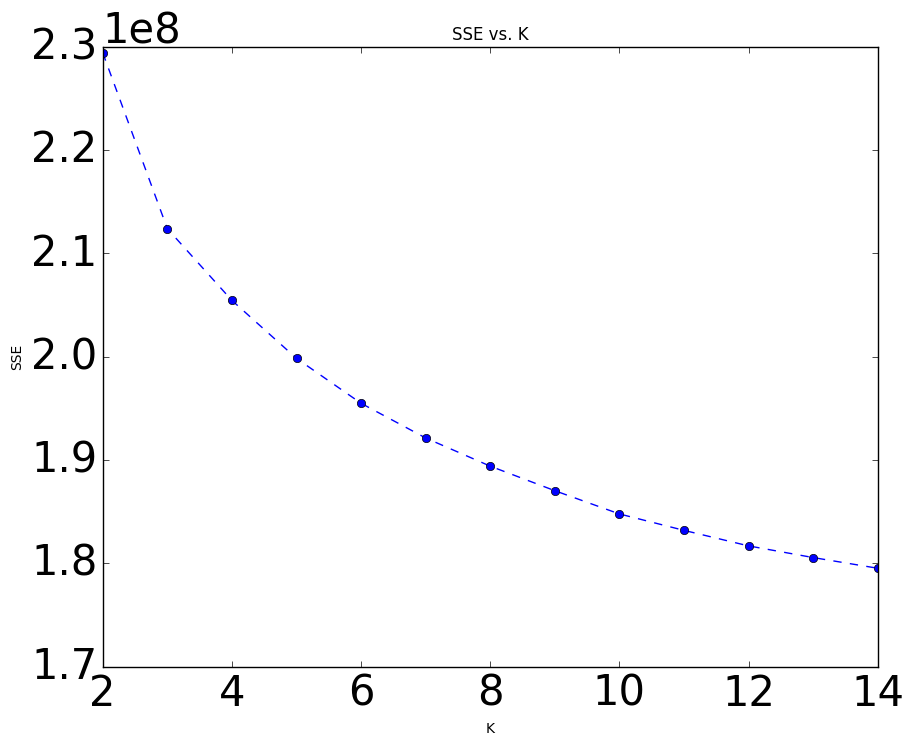

In [190]:
# Investigate the change in within-cluster distance across number of clusters.

plt.figure(figsize=(10, 8)) 
plt.plot(centers, score_list, linestyle='--', marker='o', color='b');
matplotlib.rc('xtick', labelsize=30)  
matplotlib.rc('ytick', labelsize=30)
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.show() 

### Discusion

30 classes

In [200]:
# Re-fit the k-means model with 6 class
kmeans = KMeans(n_clusters=6, random_state=42, n_jobs=-1)
labels_azdias = kmeans.fit_predict(azdias_pca)

In [201]:

class_count = pd.Series(labels_azdias).value_counts()

cls_azdias = pd.DataFrame({ 'cluster': class_count.index ,
                           '% of data': 100*class_count.values/len(labels_azdias)})
cls_azdias['data'] =  'general population'

# print cls_azdias
cls_azdias

,% of data,cluster,data
0,37.443418,3,general population
1,31.218947,2,general population
2,19.171401,5,general population
3,5.323446,4,general population
4,4.975839,0,general population
5,1.866950,1,general population


### Step 3.2: Apply All Steps to the Customer Data

In [116]:
# Load in the customer demographics data.
customers = pd.read_csv('Arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
customers.head()

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [118]:
# clean customer demographics data.
new_customers = clean_data(customers)

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [119]:
# Remove additional columns
sub_customers = new_customers[['LNR','CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']]

new_customers.drop(['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],
                   axis=1, inplace=True)

In [120]:
print('new_azdias shape', new_azdias.shape)
print('new_customers shape', new_customers.shape)

new_azdias shape (791987, 484)
new_customers shape (140899, 483)


In [124]:
#  Check for missing column in `new_customers`
mask = new_azdias.columns.isin(new_customers.columns)

miss_att = list(new_azdias.columns[~mask])
miss_att

['GEBAEUDETYP_5.0']

In [125]:
# Add the missing column with default value of 0
new_customers['GEBAEUDETYP_5.0'] = 0
new_customers['GEBAEUDETYP_5.0'] = new_customers['GEBAEUDETYP_5.0'].astype('uint8')

In [126]:
# replace missing value
new_customers = pd.DataFrame( Imp.transform(new_customers.values),
                         columns= new_customers.columns)

# scale customers variables
new_customers = pd.DataFrame(scaler.transform(new_customers.values),
                         columns= new_customers.columns)

In [202]:
# cluster predictions for the  customer demographics data.
customers_pca = pca.transform(new_customers)
labels_customers = kmeans.predict(customers_pca)

In [204]:
cus_class = pd.Series(labels_customers).value_counts()

cls_customers = pd.DataFrame({ 'cluster': cus_class.index ,
                              '% of data': 100*cus_class.values/len(labels_customers)})
cls_customers['data'] =  'customers data'

# print cls_azdias
cls_customers

,% of data,cluster,data
0,99.985096,2,customers data
1,0.014904,1,customers data


## Compare Customer Data to Demographics Data

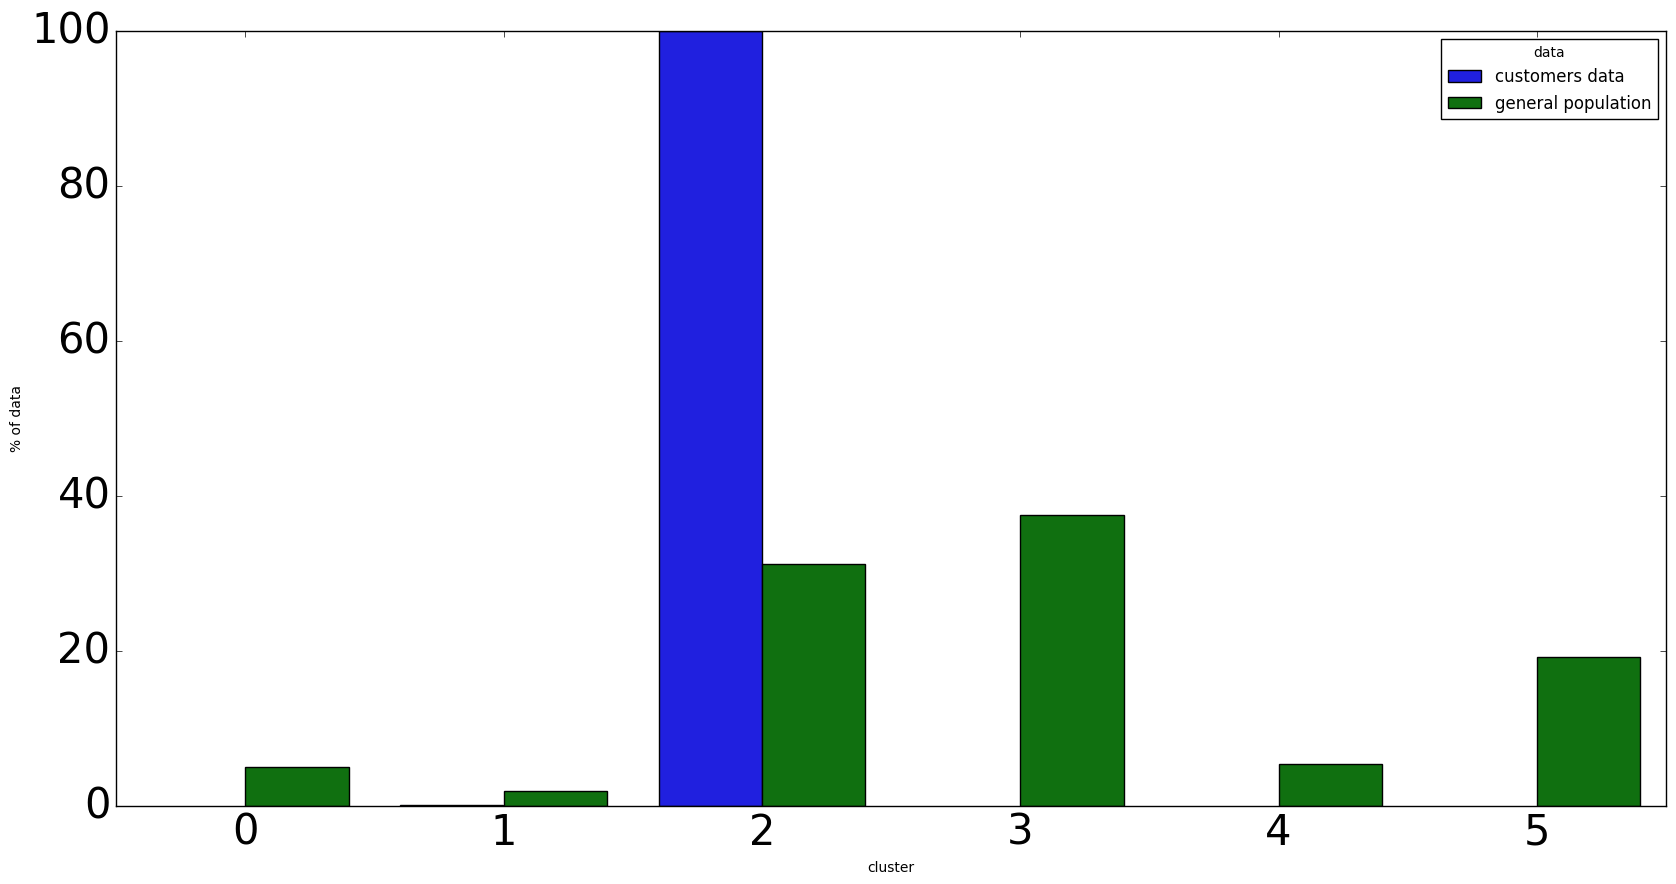

In [207]:
plt.figure(figsize=(20, 10))
sns.barplot(x="cluster", y="% of data", hue="data",
            data= pd.concat([cls_customers, cls_azdias]))
plt.show()

In [217]:
# Select peaple in the target class
target_class = [2]
target_pca = pca.inverse_transform(azdias_pca[np.isin(labels_azdias, target_class)])
target_azdias = scaler.inverse_transform(target_pca).round()
target_azdias = pd.DataFrame(target_azdias, columns=new_azdias.columns)

# Get LNR variable
target_LNR = LNR_azdias[np.isin(labels_azdias, target_class)]
target_azdias['LNR'] = target_LNR.values 
 
target_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,LNR
0,0.0,-0.0,0.0,-0.0,1.0,0.0,1.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,910220
1,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,645165
2,0.0,0.0,-0.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.0,...,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,612569
3,0.0,0.0,1.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,612595
4,-0.0,0.0,0.0,1.0,-0.0,0.0,1.0,0.0,-0.0,0.0,...,1.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,612606


In [221]:
# Select peaple in the no target class
no_target_class = [0, 1, 3, 4, 5]
no_target_pca = pca.inverse_transform(azdias_pca[np.isin(labels_azdias, no_target_class)])
no_target_azdias = scaler.inverse_transform(no_target_pca).round()
no_target_pca = pd.DataFrame(no_target_pca, columns=new_azdias.columns)

# Get LNR variable
no_target_LNR = LNR_azdias[np.isin(labels_azdias, no_target_class)]
no_target_pca['LNR'] = no_target_LNR.values 
 
no_target_pca.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,LNR
0,0.063469,0.119497,0.649701,-0.075814,0.208384,0.041771,0.688310,0.211304,0.005633,0.178835,...,0.354286,0.044368,0.068720,-0.003951,-0.071678,0.110471,0.005172,-0.118845,0.060325,910225
1,-0.103422,0.532580,0.155605,0.244301,0.098160,0.062169,0.037765,0.108221,0.085355,-0.099753,...,-0.078521,0.007658,0.715539,0.114445,-0.015227,-0.085619,0.129200,-0.073948,-0.018927,910226
2,0.271948,-0.259555,0.299131,0.177294,0.295743,0.200278,0.291330,-0.033434,0.062578,-0.034294,...,-0.158224,0.092351,0.082902,-0.002683,-0.728700,0.533396,0.048940,0.134090,-0.065348,910241
3,0.153852,0.526592,0.032059,-0.025547,0.031249,0.278589,0.343711,0.750747,-0.132546,-0.076654,...,0.016462,0.172122,0.699472,0.057077,-0.142474,0.110341,-0.016161,-0.019498,0.098936,910244
4,0.201031,0.048567,-0.026288,-0.003750,0.385696,0.395018,0.747201,-0.129658,0.045851,0.210956,...,0.297944,0.248570,0.005719,-0.017058,-0.203756,0.307205,-0.006395,-0.083380,0.029312,910248


## Discusion


Back

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Exploring the Data

In [89]:
mailout_train = pd.read_csv('Arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

mailout_train.head()

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [90]:
# Data shape
mailout_train.shape

(42962, 367)

In [91]:
# Response values
mailout_train.RESPONSE.value_counts(dropna=False)

0    42430
1      532
Name: RESPONSE, dtype: int64

## Discusion

Back

## Preparing the Data

Dont drop (feature eng)

In [92]:
# Cleaning data
clean_mailout = clean_data(mailout_train)

/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [96]:
# Response values
clean_mailout.RESPONSE.value_counts(dropna=False)

0    34663
1      437
Name: RESPONSE, dtype: int64

In [94]:
# Cheking missing values
sum_null = clean_mailout.isnull().sum(axis=1)

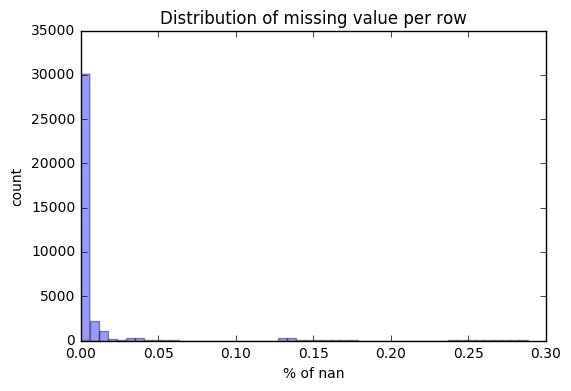

In [95]:
plt.figure()
sns.distplot(sum_null.values/485, kde=False)
plt.ylabel('count')
plt.xlabel('% of nan')
plt.title('Distribution of missing value per row')
matplotlib.rc('xtick', labelsize=10)  
matplotlib.rc('ytick', labelsize=10)
plt.show()

In [98]:
# Get LNR variable
mailout_LNR = clean_mailout['LNR'] 

# Drop LNR 
clean_mailout.drop('LNR', axis=1, inplace=True)

In [100]:
# Imputer
new_mailout = pd.DataFrame(Imp.fit_transform(clean_mailout.values),
                          columns= clean_mailout.columns)

In [101]:
# feature scaling
new_mailout = pd.DataFrame(scaler.fit_transform(new_mailout.values),
                          columns= new_mailout.columns)

## Random Over-Sampling

In [104]:
# Get class
mailout_cls_0 = new_mailout[new_mailout['RESPONSE']==0]
mailout_cls_1 = new_mailout[new_mailout['RESPONSE']==1]

print('percentage of cls 0 is: ', len(mailout_cls_0)/len(new_mailout))
print('percentage of cls 1 is: ', len(mailout_cls_1)/len(new_mailout))

percentage of cls 0 is:  0.9875498575498576
percentage of cls 1 is:  0.01245014245014245


In [121]:
# 30 times  mailout_cls_1
import random

list_index = []

for k in range(60):
    
    list_index.append(random.sample(list(mailout_cls_1.index), 218))



In [ ]:
# append
#df = mailout_cls_1

#for ind in list_index:
    
    #df_1 = pd.DataFrame(mailout_cls_1.loc[ind])
    #df = pd.concat([df, df_1])

In [ ]:
df.RESPONSE.value_counts()

1.0    437
Name: RESPONSE, dtype: int64

In [78]:
# Get LNR variable
mailout_LNR = clean_mailout['LNR'] 

# Drop LNR 
clean_mailout.drop('LNR', axis=1, inplace=True)

# split data to features and labels
response = clean_mailout['RESPONSE']

# drop RESPONSE variable
features = clean_mailout.drop('RESPONSE', axis=1)

In [79]:
# Imputer
features = pd.DataFrame(Imp.fit_transform(features.values),
                          columns= features.columns)

In [80]:
# feature scaling
features = pd.DataFrame(scaler.fit_transform(features.values),
                          columns= features.columns)

### Shuffle and Split Data
I will split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [81]:
# Split the 'features' and 'response' data into training and
# testing sets
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    response,
                                                    test_size=0.2,
                                                    random_state=42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 34369 samples.
Testing set has 8593 samples.


## Evaluating Model Performance

### Model 
XGBOOST

### Metrics

AUC

In [82]:
# function for modeling and cross-validation

def modelfit(alg, X_train, y_train, X_test, y_test, useTrainCV=True,
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train.values,
                              label=y_train.values)
        xgtest = xgb.DMatrix(X_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain,
                          num_boost_round=alg.get_params()[
                              'n_estimators'], nfold=cv_folds,
                          metrics='auc',
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print('n_estimators=', cvresult.shape[0])
        
    # Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
    
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]
    
    # Print model report
    print("\nModel Report")
    acc = metrics.accuracy_score(y_train.values,
                                 dtrain_predictions)
    print("Accuracy : %.4g" % acc)
    auc = metrics.roc_auc_score(y_train.values, dtrain_predprob)
    print("AUC Score (Train): %f" % auc)
    
    # Predict on testing data
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    test_auc = metrics.roc_auc_score(y_test.values,
                                     dtest_predprob)
    print('AUC Score (Test): %f' % test_auc)
    
    feat_imp = pd.Series(alg.feature_importances_,
                         index=X_train.columns).sort_values(ascending=False)
    # plot 20 important features
    feat_imp.iloc[:20].plot(kind='bar', title='Feature Importances')

## Step 1- Find the number of estimators for a high learning rate

n_estimators= 65

Model Report
Accuracy : 0.988
AUC Score (Train): 0.932119
AUC Score (Test): 0.740842


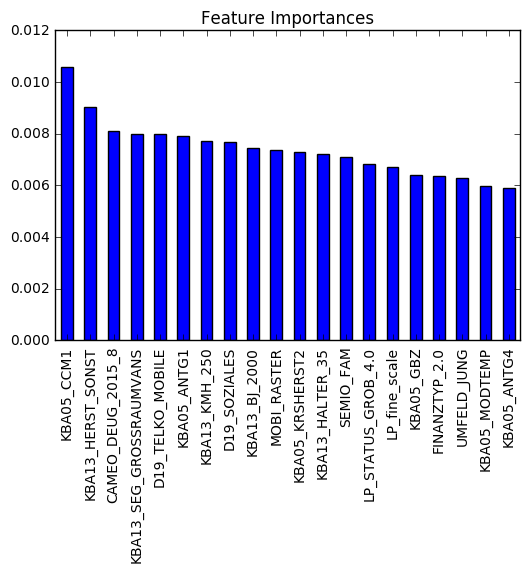

In [83]:
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)

modelfit(xgb1, X_train, y_train, X_test, y_test)

## Step 2: Tune max_depth and min_child_weight

In [84]:
# Grid seach on subsample and max_features

param_test1 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=65,
                                                  max_depth=5, min_child_weight=1, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test1, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch1.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  20 out of  60 | elapsed:  2.0min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  27 out of  60 | elapsed:  2.9min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  34 out of  60 | elapsed:  3.9min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  41 out of  60 | elapsed:  4.3min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  48 out of  60 | elapsed:  5.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  55 out of  60 | elapsed:  5.5min remaining:   29.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=65,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'max_depth': range(3, 10, 2), 'min_child_weight': range(1, 6, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [85]:
gsearch1.best_score_, gsearch1.best_params_

(0.7707045833823599, {'max_depth': 3, 'min_child_weight': 5})

In [86]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=65,
                                                  max_depth=3, min_child_weight=5, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test2, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
gsearch2.fit(X_train, y_train)

print('Best score: ', gsearch2.best_score_)
print('Best params: ', gsearch2.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  45 | elapsed:   42.3s remaining:  9.9min
[Parallel(n_jobs=-1)]: Done   8 out of  45 | elapsed:   44.8s remaining:  3.5min
[Parallel(n_jobs=-1)]: Done  13 out of  45 | elapsed:   46.1s remaining:  1.9min
/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  18 out of  45 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  23 out of  45 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed:  1.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  33 out of  45 | elapsed:  2.0min remaining:   43.2s
[Parallel(n_jobs=-1)]: Done  38 out of 

Best score:  0.7728762877696651
Best params:  {'max_depth': 2, 'min_child_weight': 5}


## Step 3: Tune gamma

In [87]:
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=65,
                                                  max_depth=2, min_child_weight=5, gamma=0,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test3, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)

gsearch3.fit(X_train, y_train)

print('Best score: ', gsearch3.best_score_)
print('Best params: ', gsearch3.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:   41.8s remaining:  8.0min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   44.0s remaining:  2.9min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   44.1s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   44.6s remaining:   56.8s
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   44.7s remaining:   35.1s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   45.1s remaining:   21.2s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   45.7s remaining:   11.4s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   45.7s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   47.4s finished


Best score:  0.7729183076835507
Best params:  {'gamma': 0.1}


### re-calibrate the number of boosting rounds for the updated parameters.

n_estimators= 83

Model Report
Accuracy : 0.988
AUC Score (Train): 0.824929
AUC Score (Test): 0.755629


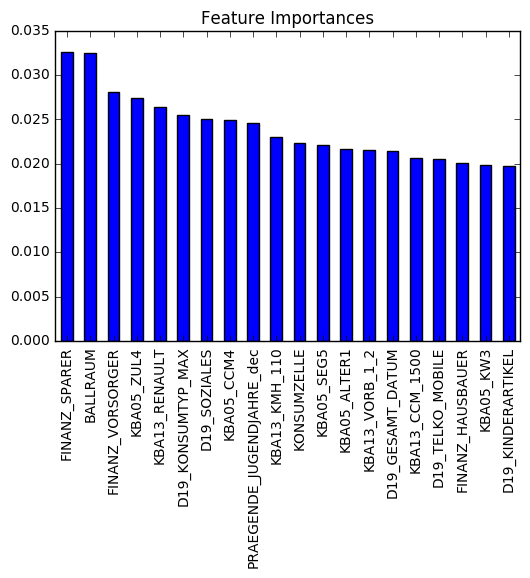

In [88]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=5,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb2, X_train, y_train, X_test, y_test)

## Step 4: Tune subsample and colsample_bytree

In [89]:
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=83,
                                                  max_depth=2, min_child_weight=5, gamma=0.1,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test4, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)

gsearch4.fit(X_train, y_train)

print('Best score: ', gsearch4.best_score_)
print('Best params: ', gsearch4.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  42 out of  80 | elapsed:  2.0min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  51 out of  80 | elapsed:  2.8min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  60 out of  80 | elapsed:  2.9min remaining:   57.2s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:  3.0min remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  78 out of  80 | elapsed:  3.2min remaining:    4.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  3.2min finished


Best score:  0.7713801139574545
Best params:  {'colsample_bytree': 0.8, 'subsample': 0.8}


### BAck

In [90]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=83,
                                                  max_depth=2, min_child_weight=5, gamma=0.1,
                                                  subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test5, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)

gsearch5.fit(X_train, y_train)

print('Best score: ', gsearch5.best_score_)
print('Best params: ', gsearch5.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   3 out of  45 | elapsed:   48.1s remaining: 11.2min
[Parallel(n_jobs=-1)]: Done   8 out of  45 | elapsed:   55.9s remaining:  4.3min
[Parallel(n_jobs=-1)]: Done  13 out of  45 | elapsed:   57.2s remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  18 out of  45 | elapsed:   58.4s remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  23 out of  45 | elapsed:  1.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  28 out of  45 | elapsed:  1.7min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  33 out of  45 | elapsed:  1.8min remaining:   39.3s
[Parallel(n_jobs=-1)]: Done  38 out of 

Best score:  0.7723328365275234
Best params:  {'colsample_bytree': 0.85, 'subsample': 0.75}


In [91]:
param_test6 = {
 'subsample':[i/100.0 for i in range(71,80,1)],
 'colsample_bytree':[i/100.0 for i in range(81,90,1)]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=83,
                                                  max_depth=2, min_child_weight=5, gamma=0.1,
                                                  subsample=0.75, colsample_bytree=0.85,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test6, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)

gsearch6.fit(X_train, y_train)

print('Best score: ', gsearch6.best_score_)
print('Best params: ', gsearch6.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   51.2s
/home/jaouadeddadsi2016/anaconda3/lib/python3.5/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 133 tasks      | ela

Best score:  0.774297710965939
Best params:  {'colsample_bytree': 0.81, 'subsample': 0.74}


 - subsample: 0.74
 -  colsample_bytree: 0.81

## Step 5: Tuning Regularization Parameters

In [92]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=83,
                                                  max_depth=2, min_child_weight=5, gamma=0.1,
                                                  subsample=0.74, colsample_bytree=0.81,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test7, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)

gsearch7.fit(X_train, y_train)

print('Best score: ', gsearch7.best_score_)
print('Best params: ', gsearch7.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  25 | elapsed:   48.6s remaining:  9.3min
[Parallel(n_jobs=-1)]: Done   5 out of  25 | elapsed:   52.9s remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   8 out of  25 | elapsed:   55.5s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed:   56.2s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  14 out of  25 | elapsed:   56.7s remaining:   44.5s
[Parallel(n_jobs=-1)]: Done  17 out of  25 | elapsed:   56.8s remaining:   26.7s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   57.0s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done  23 out of  25 | elapsed:   57.2s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   59.9s finished


Best score:  0.7752745428973113
Best params:  {'reg_alpha': 0.1}


In [93]:
param_test8 = {
 'reg_alpha':[0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
}

gsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=83,
                                                  max_depth=2, min_child_weight=5, gamma=0.1,
                                                  subsample=0.74, colsample_bytree=0.81, reg_alpha=0.1,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test8, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)

gsearch8.fit(X_train, y_train)

print('Best score: ', gsearch8.best_score_)
print('Best params: ', gsearch8.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done   3 out of  40 | elapsed:   58.8s remaining: 12.1min
[Parallel(n_jobs=-1)]: Done   8 out of  40 | elapsed:  1.0min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done  13 out of  40 | elapsed:  1.0min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:  1.1min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  23 out of  40 | elapsed:  1.1min remaining:   48.1s
[Parallel(n_jobs=-1)]: Done  28 out of  40 | elapsed:  1.7min remaining:   43.5s
[Parallel(n_jobs=-1)]: Done  33 out of  40 | elapsed:  1.7min remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  38 out of  40 | elapsed:  1.7min remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.7min finished


Best score:  0.7754466767313178
Best params:  {'reg_alpha': 0.07}


## Step 6: Reducing Learning Rate

In [97]:
param_test9 = {
 'learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

gsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=83,
                                                  max_depth=2, min_child_weight=5, gamma=0.1,
                                                  subsample=0.74, colsample_bytree=0.81, reg_alpha=0.07,
                                                  objective= 'binary:logistic', nthread=4,
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test9, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)

gsearch9.fit(X_train, y_train)

print('Best score: ', gsearch9.best_score_)
print('Best params: ', gsearch9.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done   9 out of  50 | elapsed:  1.0min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  15 out of  50 | elapsed:  1.0min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  21 out of  50 | elapsed:  1.1min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  27 out of  50 | elapsed:  1.9min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:  1.9min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:  2.0min remaining:   33.5s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  2.0min remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


Best score:  0.7765105428379021
Best params:  {'learning_rate': 0.08}


n_estimators= 122

Model Report
Accuracy : 0.988
AUC Score (Train): 0.838794
AUC Score (Test): 0.754678


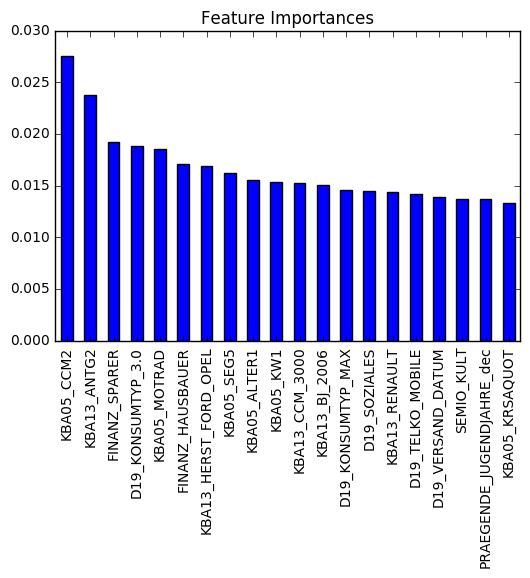

In [100]:
xgb3 = XGBClassifier(
 learning_rate =0.08,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=5,
 gamma=0.1,
 subsample=0.74,
 colsample_bytree=0.81,
 reg_alpha=0.07,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(xgb3, X_train, y_train, X_test, y_test)

In [101]:
model = XGBClassifier(learning_rate =0.08,
                      n_estimators=122,
                      max_depth=2,
                      min_child_weight=5,
                      gamma=0.1,
                      subsample=0.74,
                      colsample_bytree=0.81,
                      reg_alpha=0.07,
                      objective= 'binary:logistic',
                      nthread=4,
                      scale_pos_weight=1,
                      seed=27)

In [102]:
model.fit(X_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.81, gamma=0.1, learning_rate=0.08,
       max_delta_step=0, max_depth=2, min_child_weight=5, missing=None,
       n_estimators=122, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.07, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.74)

In [115]:
from sklearn.ensemble import RandomForestClassifier
clf_A = AdaBoostClassifier(random_state=28)

In [116]:
clf_A.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=28)

In [119]:
pred = clf_A.predict(X_test)

In [120]:
pd.Series(pred).value_counts()

0    8593
dtype: int64

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [75]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')